# Simple experiment on synthetic data to validate the method

This is the first experiment ran on a very simplified synthetic dataset. The data contains 4 anomalies, all of which are spatially separated and their amplitudes are relatively even. The data is only contaminated with pseudo-random Gaussian noise. The idea behind this simple test is to very that the method works under idea conditions and to illustrate the several processing steps.

## Imports

Load the modules needed to run the experiment.

In [1]:
import pathlib
import warnings
import rich.progress
import ipywidgets
import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches
import skimage.exposure
import harmonica as hm
import verde as vd
import mplstereonet
# Our custom module for this paper
import micromag as mg

In [2]:
# Ignore warnings coming from the Fourier transform module to avoid generating 100s of them.
warnings.filterwarnings("ignore", module="xrft")

## Generate a bunch of random models

In [3]:
models = []
for seed in range(1, 100):
    models.append(
        mg.nondipolar_source(
            xc=25, yc=25, zc=-1, position_std=0.65,
            inclination=0, declination=90, angle_std=10,
            amplitude=1e-14, amplitude_std=5e-14,
            n_particles=200, 
            seed=seed,
        )
    )

## Generate synthetic data

In [4]:
region = [0, 50, 0, 50]
x, y = vd.grid_coordinates(region=region, spacing=0.5)
sensor_sample_distances = vd.line_coordinates(1, 10, spacing=0.5)

synthetic_data = []
for dipole_coordinates, dipole_moments in models:
    data = []
    for distance in sensor_sample_distances:
        z = np.full_like(x, distance)
        coordinates = (x, y, z)
        bz = mg.dipole_bz(coordinates, dipole_coordinates, dipole_moments)
        bz += mg.gaussian_noise(error=0, shape=y.shape, seed=42)
        grid = vd.make_xarray_grid(coordinates, bz, data_names=["bz"], dims=("y", "x"), extra_coords_names="z")
        grid.x.attrs = {"units": "µm"}
        grid.y.attrs = {"units": "µm"}
        grid.bz.attrs = {"long_name": "vertical magnetic field", "units": "nT"}        
        data.append(grid)
    synthetic_data.append(data)

Make a quick plot of one of the calculated fields.

In [5]:
ipywidgets.interact(
    lambda model, height: synthetic_data[model][height].bz.plot.pcolormesh(cmap="seismic"), 
    model=(0, len(models) - 1), 
    height=(0, len(sensor_sample_distances) - 1),
)

interactive(children=(IntSlider(value=49, description='model', max=98), IntSlider(value=9, description='height…

<function __main__.<lambda>(model, height)>

## Run the Euler deconvolution and dipole moment inversion for each model

In [6]:
results = []
for grids, (dipole_coordinates, dipole_moment) in rich.progress.track(zip(synthetic_data, models), total=len(models)):
    results_per_grid = []
    for anomaly in grids:
        # Euler Deconvolution
        anomaly = anomaly.assign(mg.data_gradients(anomaly.bz)).sel(x=slice(10, 40), y=slice(10, 40))
        position, base_level = mg.euler_deconvolution(
            anomaly.bz, 
            anomaly.x_deriv, 
            anomaly.y_deriv, 
            anomaly.z_deriv,
        )
        # Dipole inversion
        moment, covariance, r2, SNR = mg.dipole_moment_inversion(anomaly.bz, position)
        results_per_grid.append((position, moment, r2))
    results.append(results_per_grid)    

Output()

## Calculate the errors in position and dipole moment

In [7]:
shape = (len(models), len(sensor_sample_distances))
x_errors = np.empty(shape)
y_errors = np.empty(shape) 
z_errors = np.empty(shape)
angle_errors = np.empty(shape)
amplitude_errors = np.empty(shape)
r2_coeffs = np.array([[r2 for _, _, r2 in estimates] for estimates in results])
assert r2_coeffs.shape == shape

for i, (estimates, (dipole_coordinates, dipole_moment)) in enumerate(zip(results, models)):    
    model_x, model_y, model_z = np.mean(dipole_coordinates, axis=1)
    model_inc, model_dec, model_amp = mg.vector_to_angles(dipole_moment.sum(axis=0))
    for j, (position, moment, r2) in enumerate(estimates):
        x_errors[i, j] = model_x - position[0]
        y_errors[i, j] = model_y - position[1]
        z_errors[i, j] = model_z - position[2]
        inc, dec, amp = mg.vector_to_angles(moment)
        amplitude_errors[i, j] = abs((amp - model_amp) / model_amp) * 100
        angle_errors[i, j] = np.degrees(
            mplstereonet.angular_distance(
                mplstereonet.line(model_inc, model_dec), mplstereonet.line(inc, dec), bidirectional=False,
            )
        )

## Plot figures for the paper

In [8]:
fig_dir = pathlib.Path("..") / "paper" / "figures"
mpl_rc = {"text.usetex": True, "font.family": "serif", "font.size": 9}

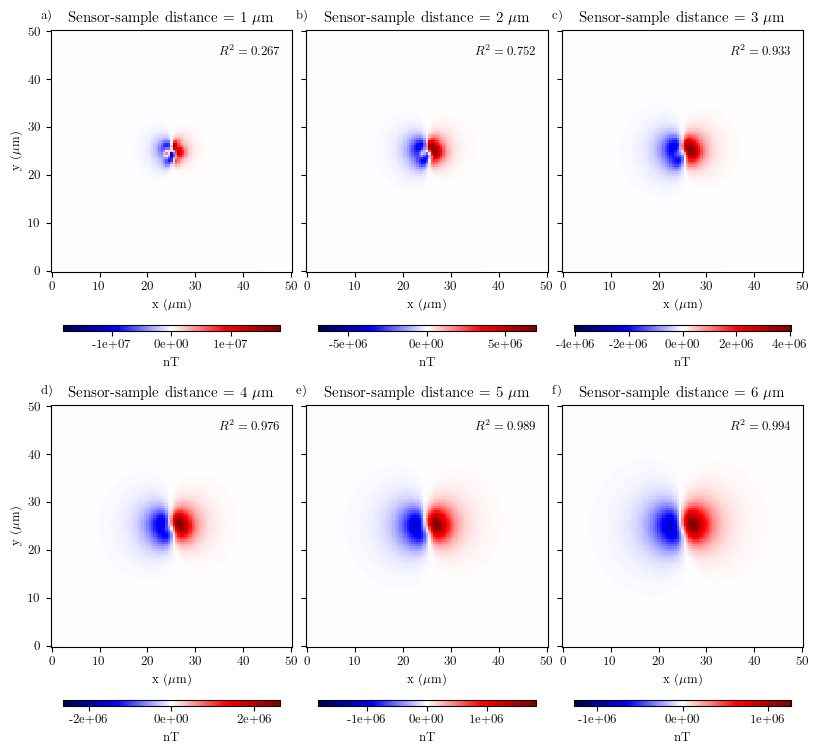

In [9]:
example_model = 39
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(2, 3, figsize=(8, 7.5), sharey="row")
    axes = axes.ravel()    
    cbar_kwargs = dict(orientation="horizontal", aspect=40, pad=0.15, shrink=0.9, format="%.0e")
    for i, height in enumerate(sensor_sample_distances[0:12:2]):
        ax = axes[i]
        ax.set_aspect("equal")
        ax.set_title(f"Sensor-sample distance = {height:.0f} $\mu$m")
        tmp = synthetic_data[example_model][i].bz.plot.pcolormesh(ax=ax, cmap="seismic", add_colorbar=False, add_labels=False)
        fig.colorbar(tmp, ax=ax, label="nT", **cbar_kwargs)
        ax.text(35, 45, f'$R^2 = {r2_coeffs[example_model, i]:.3f}$')
        ax.set_xlabel("x ($\mu$m)")
    for ax, letter in zip(axes, "a b c d e f".split()):
        ax.text(-0.04, 1.045, f"{letter})", transform=ax.transAxes)
    for ax in axes[0::3]:
        ax.set_ylabel("y ($\mu$m)")
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)    
    fig.savefig(fig_dir / "non-dipolarity-synthetic.png", dpi=200, facecolor='w', bbox_inches='tight')    
    plt.show()

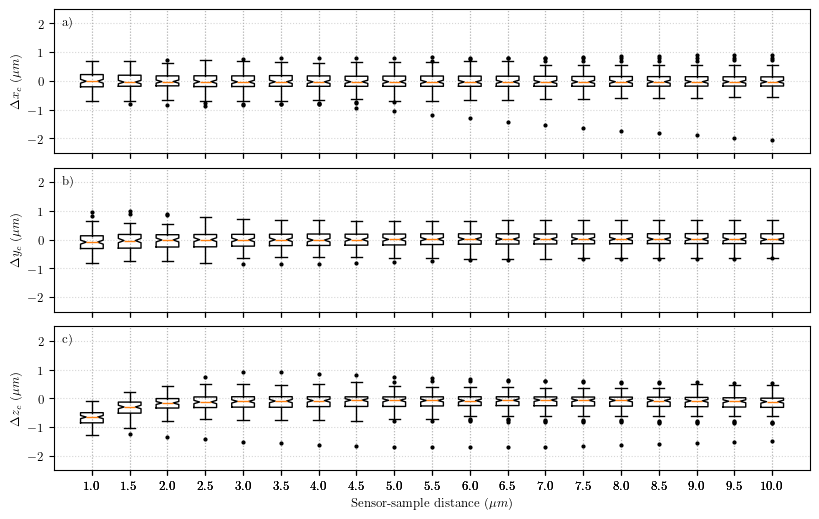

In [16]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(3, 1, figsize=(8, 5), sharex=True)
    parameters = [x_errors, y_errors, z_errors]
    ylabels = [r'$\Delta x_c~(\mu m)$', r'$\Delta y_c~(\mu m)$', r'$\Delta z_c~(\mu m)$']
    for ax, letter, parameter, ylabel in zip(axes, "a b c".split(), parameters, ylabels):
        ax.boxplot(parameter, notch=True, positions=sensor_sample_distances, widths=0.3, flierprops={'marker': '.', 'markersize': 4, 'markerfacecolor': 'k'})
#         ax.plot(sensor_sample_distances, np.median(parameter, axis=0))
        ax.set_ylabel(ylabel)
        ax.text(0.01, 0.89, f"{letter})", transform=ax.transAxes)
        ax.grid(alpha=0.5, linestyle=':')
        ax.set_ylim(-2.5, 2.5)
    plt.xlabel(r'Sensor-sample distance ($\mu m$)')
    plt.tight_layout(pad=0, h_pad=0.8, w_pad=0.4)
#     fig.savefig(fig_dir / "non-dipolarity-synthetic-positioning.png", dpi=400, facecolor='w', bbox_inches='tight')
    plt.show()

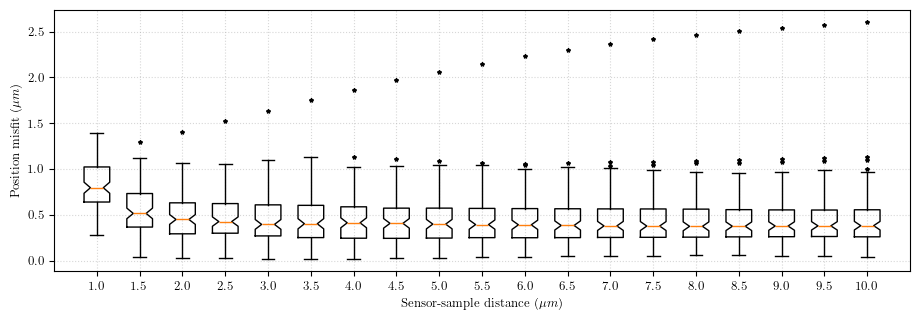

In [11]:
position_misfit = np.sqrt(x_errors**2 + y_errors**2 + z_errors**2)

with plt.rc_context(mpl_rc):
    fig, ax = plt.subplots(1, 1, figsize=(9, 3), sharex=True)

    ax.boxplot(position_misfit, notch=True, positions=sensor_sample_distances, widths=0.3, flierprops={'marker': '*', 'markersize': 3, 'markerfacecolor': 'k'})
#     ax.plot(sensor_sample_distances, np.median(position_misfit, axis=0), label=label, linestyle=linestyle)
    ax.set_ylabel(r'Position misfit ($\mu m$)')
    ax.grid(alpha=0.5, linestyle=':')
#     ax.set_ylim(-0.8, 0.8)
#     plt.legend()
    plt.xlabel(r'Sensor-sample distance ($\mu m$)')
    plt.tight_layout(pad=0, h_pad=0.8, w_pad=0.4)
    fig.savefig(fig_dir / "non-dipolarity-synthetic-positioning.png", dpi=200, facecolor='w', bbox_inches='tight')
    plt.show()

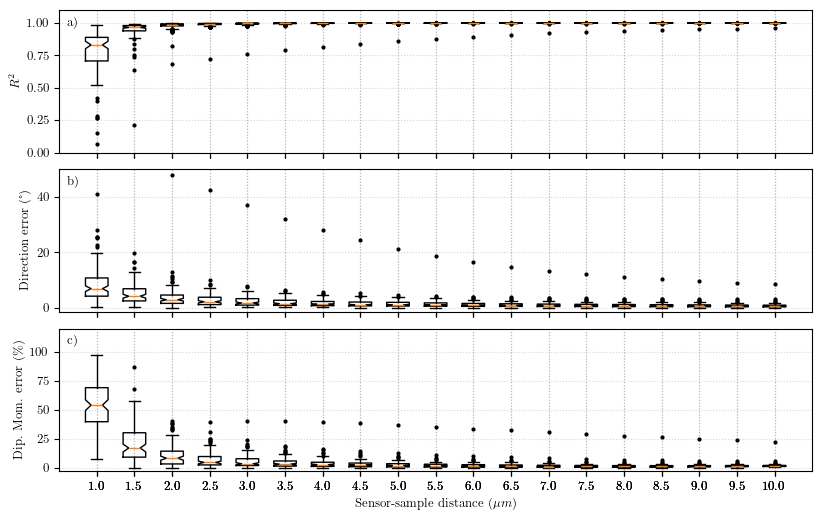

In [17]:
with plt.rc_context(mpl_rc):
    fig, axes = plt.subplots(3, 1, figsize=(8, 5), sharex=True)
    parameters = [r2_coeffs, angle_errors, amplitude_errors]
    ylabels = [r'$R^2$', 'Direction error (°)', 'Dip. Mom. error (\%)']
    for ax, letter, parameter, ylabel in zip(axes, "a b c".split(), parameters, ylabels):
        ax.boxplot(parameter, notch=True, positions=sensor_sample_distances, widths=0.3, flierprops={'marker': '.', 'markersize': 4, 'markerfacecolor': 'k'})
        ax.set_ylabel(ylabel)
        ax.text(0.01, 0.89, f"{letter})", transform=ax.transAxes)
        ax.grid(alpha=0.5, linestyle=':')
    plt.xlabel(r'Sensor-sample distance ($\mu m$)')    
    axes[0].set_ylim(0, 1.1)
    axes[1].set_ylim(-1.5, 50)
    axes[2].set_ylim(-3, 120)    
    plt.tight_layout(pad=0, h_pad=0.8, w_pad=0.4)
#     fig.savefig(fig_dir / "non-dipolarity-synthetic-inversion.png", dpi=400, facecolor='w', bbox_inches='tight')
    plt.show()